The requiered libraries

In [ ]:
!pip install pyphen

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import cmudict
import pyphen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


In [15]:
dataset_url = 'https://raw.githubusercontent.com/Romain-Jochum/NLPoetry/data_cleaning_prompt_creation/web-scraping/poem_data_with_theme.csv'
df = pd.read_csv(dataset_url)

In [16]:
df.head()

,Author,Book,Year,Title,Theme,Poem
0,Marceline Desbordes-Valmore,Romances,1830,Les cloches du soir,Absence,"Quand les cloches du soir, dans leur lente vol..."
1,Antoine de Latour,La vie intime,1833,Dix ans d'absence,Absence,"Dix ans se sont passés, dix ans ! je l'ai revu..."
2,Théophile Gautier,La comédie de la mort,1838,Absence,Absence,"Reviens, reviens, ma bien-aimée ! \n\rComme un..."
3,Pierre de Ronsard,Amours diverses,1578,L'absence,Absence,"Ce me sera plaisir, Genèvre, de t'écrire,\nÉta..."
4,André Lemoyne,Les charmeuses,1864,Retour,Absence,À Alex de Bertha.\n\n\nL'absent qu'on n'osait ...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Author  1606 non-null   object
 1   Book    1606 non-null   object
 2   Year    1606 non-null   object
 3   Title   1606 non-null   object
 4   Theme   1606 non-null   object
 5   Poem    1606 non-null   object
dtypes: object(6)
memory usage: 75.4+ KB


In [18]:
df.describe()

,Author,Book,Year,Title,Theme,Poem
count,1606,1606,1606,1606,1606,1606
unique,66,184,119,1182,141,1277
top,René-François Sully Prudhomme,Stances et poèmes,1865,Adieu,Amour,"Va, ne nous plaignons pas de nos heures d'ango..."
freq,181,59,80,8,54,3


In [19]:
invalid_years = []
for idx, year_entry in enumerate(df['Year']):
    if not str(year_entry).isdigit():
        if str(year_entry)[-4:].isdigit():
            df.loc[idx, 'Year'] = str(year_entry)[-4:]  # Keep the last 4 digits as string
        elif str(year_entry)[:4].isdigit():
            df.loc[idx, 'Year'] = str(year_entry)[:4]  # Keep the first 4 digits as string
        else:
            invalid_years.append(idx)

# Print rows where cleaning methods were applied
if invalid_years:
    print("Rows where 'Year' cleaning was applied:")
    print(df.iloc[invalid_years])

# Display the modified DataFrame
print(df)

                           Author                   Book  Year  \
0     Marceline Desbordes-Valmore               Romances  1830   
1               Antoine de Latour          La vie intime  1833   
2               Théophile Gautier  La comédie de la mort  1838   
3               Pierre de Ronsard        Amours diverses  1578   
4                   André Lemoyne         Les charmeuses  1864   
...                           ...                    ...   ...   
1601            Pierre de Ronsard       Poésies diverses  1587   
1602                Paul Verlaine                  Chair  1896   
1603           Charles Baudelaire      Les fleurs du mal  1857   
1604           Charles Baudelaire      Les fleurs du mal  1857   
1605             Alfred de Musset      Poésies posthumes  1888   

                    Title    Theme  \
0     Les cloches du soir  Absence   
1       Dix ans d'absence  Absence   
2                 Absence  Absence   
3               L'absence  Absence   
4                

In [ ]:
convertible_rows = []
invalid_rows = []

for idx, year_entry in enumerate(df['Year']):
    if str(year_entry).isdigit():
        try:
            df.loc[idx, 'Year'] = int(year_entry)
            convertible_rows.append(idx)
        except ValueError:
            invalid_rows.append(idx)
    else:
        invalid_rows.append(idx)

#if convertible_rows:
#    print("Rows where 'Year' was successfully converted to integer:")
#    print(df.iloc[convertible_rows])

if invalid_rows:
    print("\nRows where 'Year' could not be converted to integer:")
    print(df.iloc[invalid_rows])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Author  1606 non-null   object
 1   Book    1606 non-null   object
 2   Year    1606 non-null   object
 3   Title   1606 non-null   object
 4   Theme   1606 non-null   object
 5   Poem    1606 non-null   object
dtypes: object(6)
memory usage: 75.4+ KB


In [28]:
df['Author'] = df['Author'].astype('category')  # Use 'category' data type for 'Author'
df['Book'] = df['Book'].astype('category')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce', downcast='integer')  # Convert 'Year' to integers
df['Title'] = df['Title'].astype('category')
df['Theme'] = df['Theme'].astype('category')
df['Poem'] = df['Poem'].astype(str)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Author  1606 non-null   category
 1   Book    1606 non-null   category
 2   Year    1606 non-null   int16   
 3   Title   1606 non-null   category
 4   Theme   1606 non-null   category
 5   Poem    1606 non-null   object  
dtypes: category(4), int16(1), object(1)
memory usage: 81.6+ KB


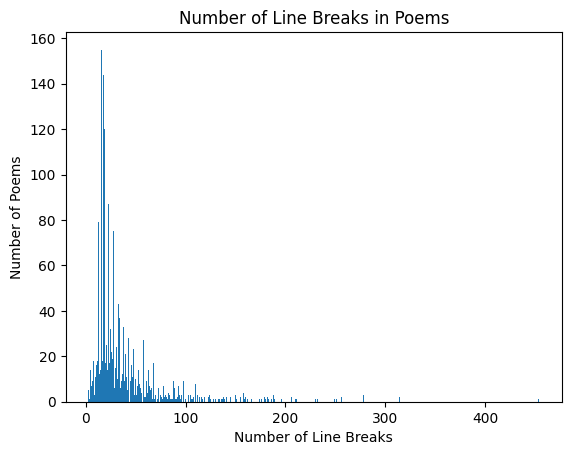

In [30]:
df_format = df.copy()

df_format['Line_Breaks'] = df_format['Poem'].str.count('\n')

# Count consecutive line breaks
df_format['Consecutive_Line_Breaks'] = df_format['Poem'].str.count('\n+')

# Plot the number of poems with different numbers of line breaks
line_break_counts = df_format['Line_Breaks'].value_counts().sort_index()
plt.bar(line_break_counts.index, line_break_counts.values)
plt.xlabel('Number of Line Breaks')
plt.ylabel('Number of Poems')
plt.title('Number of Line Breaks in Poems')
plt.show()

In [ ]:
df_sorted = df_format.sort_values(by='Line_Breaks', ascending=False)

# Display poems with the highest number of line breaks
highest_line_breaks_poems = df_sorted.head(5)['Poem']  # Display top 5 poems with highest line breaks
for poem in highest_line_breaks_poems:
    print(f"Poem:\n{poem}\n")
    print(f"\n––––––––––†–––––––––\n")

In [34]:
initial_rows_count = len(df_format)

df_unique = df_format.drop_duplicates(keep='first')

dropped_rows_count = initial_rows_count - len(df_unique)

# Display the number of dropped rows
print(f"Number of dropped rows: {dropped_rows_count}")

Number of dropped rows: 1


In [ ]:
df_unique['Line_Breaks'] = df_unique['Poem'].str.count('\n')
df_unique['Total_Characters'] = df_unique['Poem'].str.len()
df_unique['Line_Break_Ratio'] = df_unique['Line_Breaks'] / df_unique['Total_Characters']
df_unique['Consecutive_Line_Breaks_Ratio'] = df_unique['Consecutive_Line_Breaks'] / df_unique['Total_Characters']

# Sort the DataFrame by 'Line_Break_Ratio' column in descending order
df_sorted_unique = df_unique.sort_values(by='Consecutive_Line_Breaks_Ratio', ascending=False)

# Display poems with the highest line break ratio
highest_line_break_ratio_poems = df_sorted_unique.head(5)['Poem']  # Display top 5 poems with highest line break ratio
for poem in highest_line_break_ratio_poems:
    print(f"Poem:\n{poem}\n")
    print(f"\n––––––––––†–––––––––\n")

In [37]:
print(df_unique)

                           Author                   Book  Year  \
0     Marceline Desbordes-Valmore               Romances  1830   
1               Antoine de Latour          La vie intime  1833   
2               Théophile Gautier  La comédie de la mort  1838   
3               Pierre de Ronsard        Amours diverses  1578   
4                   André Lemoyne         Les charmeuses  1864   
...                           ...                    ...   ...   
1601            Pierre de Ronsard       Poésies diverses  1587   
1602                Paul Verlaine                  Chair  1896   
1603           Charles Baudelaire      Les fleurs du mal  1857   
1604           Charles Baudelaire      Les fleurs du mal  1857   
1605             Alfred de Musset      Poésies posthumes  1888   

                    Title    Theme  \
0     Les cloches du soir  Absence   
1       Dix ans d'absence  Absence   
2                 Absence  Absence   
3               L'absence  Absence   
4                

In [39]:
df_unique.describe()

,Year,Line_Breaks,Consecutive_Line_Breaks,Total_Characters,Line_Break_Ratio,Consecutive_Line_Breaks_Ratio
count,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000
mean,1843.423053,37.791900,32.232399,1319.720249,0.029854,0.025070
std,72.132186,38.466964,33.967605,1471.903466,0.007989,0.006340
min,1552.000000,3.000000,3.000000,121.000000,0.005940,0.002970
25%,1833.000000,18.000000,14.000000,648.000000,0.023988,0.020186
50%,1860.000000,24.000000,21.000000,810.000000,0.027624,0.022989
75%,1875.000000,43.000000,38.000000,1420.000000,0.035129,0.029326
max,1982.000000,454.000000,438.000000,20901.000000,0.073836,0.060498


In [ ]:
def count_structure(poem_text):
    verses = poem_text.split('\n\n')  # Assume empty lines separate verses
    verse_count = len(verses)
    stanza_count = len(re.findall(r'\n\n', poem_text))  # Assume empty lines separate stanzas
    return verse_count, stanza_count

# Apply the function to create new columns
df_unique[['Verse_Count', 'Stanza_Count']] = df_unique['Poem'].apply(count_structure).apply(pd.Series)

In [55]:
dic = pyphen.Pyphen(lang='fr_FR')


def analyze_meter(poem_text):
    syllable_counts = []
    verses = poem_text.split('\n\n')  # Assume empty lines separate verses
    if len(verses) in [3, 4, 6]:
        for line in poem_text.split('\n'):
            words = re.findall(r'\w+', line.lower())  # Extract words from line
            syllable_count = sum(len(dic.inserted(word).split('-')) for word in words)
            #sum([len(list(d[word.lower()][0])) for word in words if word.lower() in d])  # Count syllables using CMU Pronouncing Dictionary
            syllable_counts.append(syllable_count)

        # Determine the predominant meter type
        syllable_counts_counter = Counter(syllable_counts)
        predominant_meter = max(syllable_counts_counter, key=syllable_counts_counter.get)

        if predominant_meter == 12:
          return 'alexandrin'  # Alexandrine meter has 12 syllables per line

        elif predominant_meter == 10:
          return 'décasyllabe'

        elif predominant_meter == 8:
          return 'octosyllabe'

        else:
          return 'metre libre'

    else:
        return 'vers libre'


df_unique['Meter'] = df_unique['Poem'].apply(analyze_meter)

print(df_unique)

                           Author                   Book  Year  \
0     Marceline Desbordes-Valmore               Romances  1830   
1               Antoine de Latour          La vie intime  1833   
2               Théophile Gautier  La comédie de la mort  1838   
3               Pierre de Ronsard        Amours diverses  1578   
4                   André Lemoyne         Les charmeuses  1864   
...                           ...                    ...   ...   
1601            Pierre de Ronsard       Poésies diverses  1587   
1602                Paul Verlaine                  Chair  1896   
1603           Charles Baudelaire      Les fleurs du mal  1857   
1604           Charles Baudelaire      Les fleurs du mal  1857   
1605             Alfred de Musset      Poésies posthumes  1888   

                    Title    Theme  \
0     Les cloches du soir  Absence   
1       Dix ans d'absence  Absence   
2                 Absence  Absence   
3               L'absence  Absence   
4                

<ipython-input-55-f3111fc85d62>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Meter'] = df_unique['Poem'].apply(analyze_meter)


In [56]:
selected_columns = ['Author', 'Book', 'Year', 'Title', 'Theme', 'Poem', 'Meter']

df_unique[selected_columns].to_csv('processed_dataset.csv', index=False)

In [59]:
"""
!pip install xlsxwriter
import xlsxwriter

df_unique.to_excel('data.xls', sheet_name='Sheet1', index=False, engine='xlsxwriter')
"""

  Using cached XlsxWriter-3.2.0-py3-none-any.whl (159 kB)
